In [5]:
# Standard library imports
import csv
import html
import os
import re
from collections import defaultdict
from datetime import datetime
import sys

# Third-party library imports
import ftfy
import geonamescache
import locationtagger
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn2
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import psutil
import regex
import importlib
import seaborn as sns
import spacy
from joblib import Parallel, delayed
from langdetect import detect_langs, LangDetectException, DetectorFactory
from unidecode import unidecode

# Local application/library specific imports
sys.path.insert(0, '../Utility files')
import utils2


## Filtering, Preprocessing, and Language and Location Detection

This markdown contains the initial data cleaning and filters applied to the data.



Markdown overview:
1. Data Inspection and duplicate removal 
    - Summary statistics of users and brands.
    - Any missing data, duplicates etc.

2. Filters to match the SES embedding method:
    On the marker-follower (edgelist) df:
    - Remove users that follow less than 5 (or more) brands
    - Match the Follower_Ids in the now filtered marker-follower df with the follower-bio df. As such, the follower bios will only include users that follow more than five brands. Subsequent filters will be on the correct users (up to date follower-bios).

    On the follower-bios df:
    - Remove users with less than 25 followers
    - Remove users with less than 100 tweets
    - Clean the description column (normalise, remove emojis etc.)

3. Keep only french accounts
    - Keep only users who have both french bios and a location that can be surely detected to be in France

4. Create an informative edgelist to use further in the analyses
- This involves gathering the marker types associated with each marker-folower pair.
- I am making one for the full data and one for the french users only.


Files created that will be used further on:
- followers_bios_french_updated.csv : the df with followers and their bios. Followers are french, and all filters have been applied
- french_edgelist_marker_threshold.csv: french edgelist with all filters applied

### Load files 

In [6]:
# Load the data df of markers and their followers

# Load markers-followers (later referred to as edgelist)
load_path = '/home/livtollanes/SocialMarkers'
file = 'markers_followers_2023-05-19.csv'
file_path = os.path.join(load_path, file)

req_cols = ['id', 'follower_id']
dtypes = {'id': 'object',
          'follower_id': 'object'}

# Use pandas to load the csv file
markers_followers = pd.read_csv(file_path, usecols=req_cols, dtype=dtypes)

# Rename the twitter id column to follower id 
markers_followers.rename(columns={'id':'marker_id'}, inplace=True)

In [7]:
# Load the followers bios and rename ID columns
load_path = '/home/livtollanes/SocialMarkers'
file = 'markers_followers_bios_2023-05-19.csv'
file_path = os.path.join(load_path, file)

req_cols = ['twitter_id', 'id', 'screen_name', 'description', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists','timestamp_utc']

dtypes = {
    'twitter_id': 'object',
    'id': 'object',
    'screen_name': 'object',
    'description': 'object',
    'location': 'object',
    'tweets': 'float64',
    'followers': 'float64',
    'friends': 'float64',
    'witheld_in_countries': 'float64'
}

# Use pandas to load the csv file
followers_bios = pd.read_csv(file_path, usecols=req_cols, dtype=dtypes)

# Rename the twitter id column to follower id 
followers_bios.rename(columns={'twitter_id':'follower_id'}, inplace=True)

## 1. Data Inspection and Duplicate Removal

- There are 2,357,493 duplicate rows in the edgelist

In [5]:
#Inspection of the data
utils2.summary_stats(followers_bios, print_dtypes=False)
importlib.reload(utils2)
utils2.summary_stats(markers_followers, print_dtypes=False)

Shape of DataFrame:  (70666646, 11)

Columns in DataFrame:  ['follower_id', 'id', 'screen_name', 'description', 'timestamp_utc', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists']

Number of unique values in 'follower_id':  70666646
Number of duplicate values in 'follower_id':  0

Number of unique values in 'id':  70642661
Number of duplicate values in 'id':  23984

Number of missing values in each column:
'follower_id':  0
'id':  23985
'screen_name':  23986
'description':  42027215
'timestamp_utc':  23985
'location':  47956041
'tweets':  23985
'followers':  23985
'friends':  23985
'likes':  23985
'lists':  23985

Number of duplicate rows:  0


In [8]:
# # Duplicate inspection - do they look like duplicates?

# # Sort the DataFrame to ensure that duplicates are next to each other
# markers_followers_sorted = markers_followers.sort_values(by=list(markers_followers.columns))

# # Find duplicates in the sorted DataFrame
# duplicates = markers_followers_sorted[markers_followers_sorted.duplicated(keep=False)]

# # Print the first 10 rows of duplicates (5 pairs)
# print(duplicates.head(10))

#drop the duplicates in markers_followers
markers_followers.drop_duplicates(keep='first', inplace=True)

In [10]:
#Does the follower bio df contain the same followers as the edgelist?
utils2.compare_column_values(followers_bios, markers_followers, 'follower_id') # Yes 

There are 30351 unique values in df1 that don't exist in df2.
There are 0 unique values in df2 that don't exist in df1.


## 2. Filters to match the SES embedding method implementation

- Filter the marker-follower df:
    - Remove users that follow less than 5 (or more) brands
    - Streamline the edgelist df and the follower bio df so that any filters applied to one df is reflected in the other

- Filter the followers-bios df:
    - Remove users witrh less than 25 followers
    - Remove users with less than 100 tweets
    - Clean the description column. (Remove emojis, weird characters etc.)

#### Marker-follower df filtering

In [11]:
# Remove users that follow less than 5 brands
n = 5  # minimal number of brands followed required to be included in the analysis
markers_followers_5 = utils2.filter_followers(df = markers_followers, follower_id_column = 'follower_id', min_brands= n)

66693204 followers follow less than 5 brands (94.42% of the total followers).
After removing these followers, 3943091 followers are left (5.58% of the followers in the inputted df).


In [12]:
### What brands were removed in the process?

# Get the unique marker_id values in the original and filtered DataFrames
original_brands = set(markers_followers['marker_id'].unique())
filtered_brands = set(markers_followers_5['marker_id'].unique())

# Find the brands that are in the original DataFrame but not in the filtered DataFrame
removed_brands = original_brands - filtered_brands

# Print the removed brands
print("Removed brands:", removed_brands) #corresponds to "Napapijiri97", which kinda sounds like a fake profile


Removed brands: {'1059975643'}


In [13]:
# Streamline the follower bio df to be streamlined with the filter applied to the edgelist
followers_bios_5 = utils2.streamline_IDs(source = markers_followers_5, df_tofilter= followers_bios, column = 'follower_id')

utils2.compare_column_values(followers_bios_5, markers_followers_5, 'follower_id')   # The two dfs are streamlined so far

Number of unique follower_id in source DataFrame: 3943091
Number of unique follower_id in filtered DataFrame after filtering: 3943091
Removed 66723555 rows from the DataFrame to be filtered.
3943091 rows are left in the filtered DataFrame.
There are 0 unique values in df1 that don't exist in df2.
There are 0 unique values in df2 that don't exist in df1.


#### Follower-bios filtering:
- Remove users with less than 25 followers
- Remove users with less than 100 tweets
- Update the markers-followers df to match the now filtered bio df

In [14]:
# Minimum of 25 followers and 100 tweets
followers_bios_fullfilter = utils2.filter_by_tweets_and_followers(followers_bios_5, min_followers= 25, min_tweets= 100)


#Streamline dfs again
markers_followers_fullfilter = utils2.streamline_IDs(source= followers_bios_fullfilter, df_tofilter=markers_followers_5, column='follower_id')

utils2.compare_column_values(followers_bios_fullfilter, markers_followers_fullfilter , 'follower_id') # dfs are streamlined

Removed 2750559 rows.
1192532 rows are left.
Number of unique follower_id in source DataFrame: 1192532
Number of unique follower_id in filtered DataFrame after filtering: 1192532
Removed 18992709 rows from the DataFrame to be filtered.
9614122 rows are left in the filtered DataFrame.
There are 0 unique values in df1 that don't exist in df2.
There are 0 unique values in df2 that don't exist in df1.


In [21]:
utils2.summary_stats(markers_followers_fullfilter, print_dtypes=False)

Shape of DataFrame:  (9614122, 2)

Columns in DataFrame:  ['marker_id', 'follower_id']

Number of unique values in 'follower_id':  1192532
Number of duplicate values in 'follower_id':  8421590

Number of unique values in 'marker_id':  235
Number of duplicate values in 'marker_id':  9613887

Number of missing values in each column:
'marker_id':  0
'follower_id':  0

Number of duplicate rows:  0


In [15]:
#clean description column to avoid writing problems
followers_bios_fullfilter = utils2.process_description(followers_bios_fullfilter, 'description')

In [22]:

# #Now write the two dfs to csvs to save them in case something happens
# markers_followers_fullfilter.to_csv('/home/livtollanes/NewData/initial_dfs/markers_followers_nolang.csv.csv', encoding='utf-8', index=False)

# followers_bios_fullfilter.to_csv('/home/livtollanes/NewData/initial_dfs/followers_bios_nolang.csv', sep=',', encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)

## 3. Language Filtering: keep only french accounts
- We only want french language bios to be included in further analyses


#### Load data and double check for errors

In [22]:
# #Load the filtered edgelist 
# full_path1 = '/home/livtollanes/NewData/markers_followers_nolang.csv'
# req_cols = ['marker_id', 'follower_id']
# dtypes = {'marker_id': 'object',
#           'follower_id': 'object'}

# markers_followers = pd.read_csv(full_path1, encoding='utf-8', dtype=dtypes, usecols=req_cols)

In [23]:
# # #Loading the cleaned and filtered followers bios 
# full_path = '/home/livtollanes/NewData/initial_dfs/followers_bios_nolang.csv'

# req_cols = ['follower_id', 'screen_name', 'description', 'description_cleantext', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists','timestamp_utc']

# dtypes = {
#     'follower_id': 'object',
#     'screen_name': 'object',
#     'description': 'object',
#     'description_cleantext': 'object',
#     'location': 'object',
#     'tweets': 'float64',
#     'followers': 'float64',
#     'friends': 'float64'
# }

# follower_bios = pd.read_csv(full_path, usecols=req_cols, dtype=dtypes, engine= 'python')

In [21]:
utils2.compare_column_values(follower_bios, markers_followers, 'follower_id') #The follower_ids are still streamlined, indicating that writing and reading of the cleaned dfs was successful

#summary stats on the dfs again, to make sure that no strange things have happened during the cleaning process
utils2.summary_stats(follower_bios, print_dtypes= False)
utils2.summary_stats(markers_followers, print_dtypes= False)

#everything looks fine

There are 0 unique values in df1 that don't exist in df2.
There are 0 unique values in df2 that don't exist in df1.
Shape of DataFrame:  (1192532, 12)

Columns in DataFrame:  ['follower_id', 'id', 'screen_name', 'description', 'timestamp_utc', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists', 'description_cleantext']

Number of unique values in 'follower_id':  1192532
Number of duplicate values in 'follower_id':  0

Number of unique values in 'id':  1192532
Number of duplicate values in 'id':  0

Number of missing values in each column:
'follower_id':  0
'id':  0
'screen_name':  0
'description':  296871
'timestamp_utc':  0
'location':  376685
'tweets':  0
'followers':  0
'friends':  0
'likes':  0
'lists':  0
'description_cleantext':  0

Number of duplicate rows:  0
Shape of DataFrame:  (9614122, 2)

Columns in DataFrame:  ['marker_id', 'follower_id']

Number of unique values in 'follower_id':  1192532
Number of duplicate values in 'follower_id':  8421590

Number of unique

#### The language detection

The language detection is performed with the langdetect package. This package is based on Google's language detection API. 


In [22]:
# Create a copy of the DataFrame for each function
follower_bios_copy = follower_bios.copy()

# Use the copied DataFrame in the functions. Add and detect language to the lang df
lang = utils2.add_and_detect_language(follower_bios_copy, 'description_cleantext', seed = 3)


In [23]:
#Language stats
utils2.calculate_language_percentages(lang, 'language') 

French:  268867 ( 22.545893946661387 %)
English:  353202 ( 29.61782157627636 %)
Unknown:  327270 ( 27.443288733551803 %)
Other:  243193 ( 20.39299574351046 %)
NaN in description_cleantext:  0 ( 0.0 %)


In [24]:
# Overview of number of users with bios and locations
utils2.location_bio_stats(lang)

Unique locations: 231725 (19.4%)
Users with location data: 815847 (68.4%)
Users without location data: 376685 (31.6%)
Users with bios: 1192532 (100.0%)
Users without bios: 0 (0.0%)
Users with both location and bios: 815847 (68.4%)


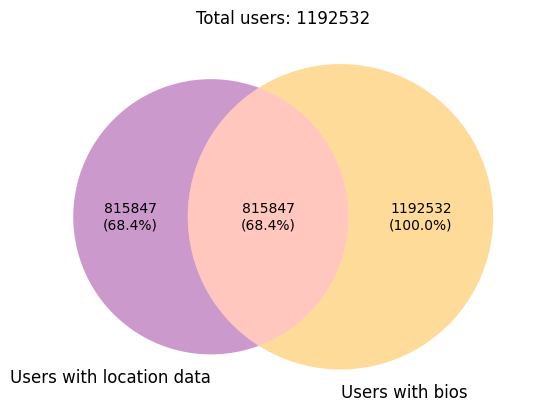

In [25]:
#Plot the intersection of users with bios and locations

# Calculate the number of users for each category
total_users = lang.shape[0]
users_with_location = lang['location'].notna().sum()
users_with_bios = lang['description_cleantext'].notna().sum()
users_with_both = lang[(lang['location'].notna()) & (lang['description_cleantext'].notna())].shape[0]

# Create the Venn diagram with custom colors
v = venn2(subsets=(users_with_location, users_with_bios, users_with_both),
    set_labels=('Users with location data', 'Users with bios'),
    set_colors=('purple', 'orange'))

# Calculate the percentages
location_percentage = users_with_location / total_users * 100
bios_percentage = users_with_bios / total_users * 100
both_percentage = users_with_both / total_users * 100

# Modify the labels of the subsets to include the percentages
v.get_label_by_id('10').set_text(f'{users_with_location}\n({location_percentage:.1f}%)')
v.get_label_by_id('01').set_text(f'{users_with_bios}\n({bios_percentage:.1f}%)')
v.get_label_by_id('11').set_text(f'{users_with_both}\n({both_percentage:.1f}%)')

# Add the total number of users to the title
plt.title(f'Total users: {total_users}')

plt.show()

Location (country) search using GeonamesCache

In [26]:
gc = geonamescache.GeonamesCache()
all_cities = gc.get_cities()

# Filter cities by country code
cities = {k: v for k, v in all_cities.items() if v['countrycode'] == 'FR'}

# Convert the cities dictionary to a list of tuples
cities_list = [(city['name'], city['population']) for city in cities.values()]

# Sort the list by population in descending order and take the first 1000
biggest_cities = sorted(cities_list, key=lambda x: x[1], reverse=True)[:652]

# Print the  biggest cities
for city, population in biggest_cities:
    print(city, population)

Paris 2138551
Marseille 870731
Lyon 522969
Toulouse 493465
Nice 342669
Nantes 318808
Strasbourg 274845
Bordeaux 260958
Montpellier 248252
Rouen 234475
Lille 234475
Rennes 220488
Reims 196565
Le Havre 185972
Cergy-Pontoise 183430
Saint-Étienne 176280
Toulon 168701
Angers 168279
Grenoble 158552
Dijon 158002
Nîmes 148236
Clermont-Ferrand 147865
Aix-en-Provence 146821
Saint-Quentin-en-Yvelines 146598
Brest 144899
Le Mans 144515
Amiens 143086
Tours 141621
Limoges 141176
Villeurbanne 131445
Besançon 128426
Metz 123914
Orléans 116269
Mulhouse 111430
Montreuil 111240
Perpignan 110706
Caen 110624
Boulogne-Billancourt 108782
Nancy 105058
Lyon 03 102725
Argenteuil 101475
Roubaix 98828
Tourcoing 98656
Saint-Denis 96128
Avignon 89769
Marseille 13 89316
Asnières-sur-Seine 86742
Nanterre 86719
Lyon 08 86154
Poitiers 85960
Versailles 85416
Courbevoie 85158
Créteil 84833
Pau 82697
Lyon 07 82573
Colombes 82300
Vitry-sur-Seine 81001
Aulnay-sous-Bois 80615
Marseille 08 78837
Marseille 15 77770
Marseille 0

In [27]:
# Extract city names from biggest_cities list
city_names = [city[0] for city in biggest_cities]

# Add 'france' to the list of city names
city_names.append('france')

# Convert all city names to lowercase to ignore case
city_names = [city.lower() for city in city_names]

# Convert location column to lowercase to ignore case
lang['location'] = lang['location'].str.lower()

# Based on the location column, assign either country France or other 
# Apply the function to the 'location' column and assign the result to a new 'country' column
lang['country'] = lang['location'].apply(lambda x: utils2.assign_country(x, city_names))


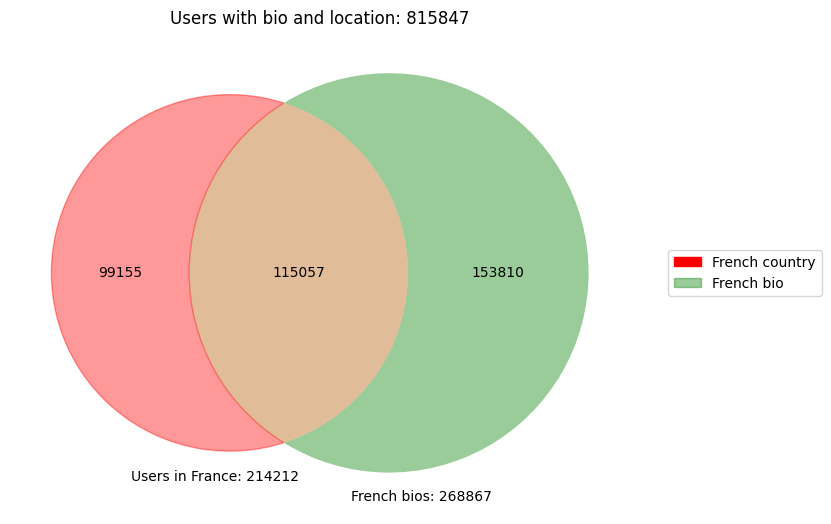

In [28]:
# Calculate the intersections - bios and locations
french_country_french_language = lang[(lang['country'] == 'France') & (lang['language'] == 'fr')].shape[0]
french_country_other_language = lang[(lang['country'] == 'France') & (lang['language'] != 'fr')].shape[0]

french_country = lang[lang['country'] == 'France'].shape[0]
french_bio = lang[lang['language'] == 'fr'].shape[0]

users_with_both = lang[(lang['location'].notna()) & (lang['description_cleantext'].notna())].shape[0]

# Define the set sizes and the intersection sizes
venn_labels = {'10': french_country_other_language, 
               '01': french_bio - french_country_french_language, 
               '11': french_country_french_language}

# Calculate the total number of users
total_users = users_with_both

plt.figure(figsize=(8, 8))
venn = venn2(subsets=venn_labels, set_labels=(None, None))

# Set 'French country' to red
venn.get_patch_by_id('10').set_color('red')

# Add a title
plt.title(f'Users with bio and location: {total_users}')

# Create the legend
french_country_patch = mpatches.Patch(color='red', label='French country')  # Set 'French country' to red in the legend
french_language_patch = mpatches.Patch(color=venn.get_patch_by_id('01').get_facecolor(), label='French bio')
plt.legend(handles=[french_country_patch, french_language_patch], bbox_to_anchor=(1.05, 0.5), loc='center left')

# Add the total count per category underneath each circle
plt.text(-0.25, -0.5, f'Users in France: {french_country}', ha='center')
plt.text(0.25, -0.55, f'French bios: {french_bio}', ha='center')

# Display the plot
plt.show()

#The numbers change abit each time the language detection is ran, because I did not set a seed and the language detection is probabilistic

In [29]:
#separate dfs for the different categories
french_bio_not_france = lang[(lang['language'] == 'fr') & (lang['country'] != 'France')]
in_france_nofrenc_bio = lang[(lang['language'] != 'fr') & (lang['country'] == 'France')]
bio_and_country = lang[(lang['language'] == 'fr') & (lang['country'] == 'France')]

In [42]:
# # how many rows in french_bio_not_france in the column location are NA?
# french_bio_not_france['location'].isna().sum()

# #print a selected interval of the rows in french_bio_not_france that are NA in location
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
# french_bio_not_france[french_bio_not_france['location'].isna()][['description_cleantext', 'language', 'location', 'country']].iloc[20:30]

,description_cleantext,language,location,country
280,Quand le silence devient notre seule option...!!!!!,fr,NaN,Other
307,Tout £st possible à celui qui cΠoi,fr,NaN,Other
315,Ex président de la fédération des buralistes d'Ile de France,fr,NaN,Other
374,Co-créateur du projet @transmission_s_ Salarié de la protection de l'enfance Militant #Paris13 Acteur dans la troupe des @amis_1871,fr,NaN,Other
394,"du soleil, des fleurs, du rock et beaucoup d’amour",fr,NaN,Other
405,Artiste peintre et écrivain en art spirituel divine et sculpteur,fr,NaN,Other
418,Rien d'spécial,fr,NaN,Other
420,Life is a Joke. Vie ta vie au jour le jour. BrunoMars.Instagram&Snapchat: jujubb2,fr,NaN,Other
438,"Journaliste France Culture, Vannes - Paris Paris - Vannes du reportage ici et là-bas.",fr,NaN,Other
441,Head of Marketing Communication Passionné par l’artisanat et le design ! #HigherEd #cobranding #mode #couture #luxe,fr,NaN,Other


In [23]:
# #Write the language df to csv to save it in case something happens
# bio_and_country.to_csv('/home/livtollanes/NewData/DataWrangling/inital_dfs/followers_bios_french.csv', sep=',', encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)

## 4. Create informative edgelists

An informative edgelist is created via some data wrangling. The informative edgelist contains the types of the markers.

One for the no language data, and one for french users. Just in case I need to revisit something

### Non language edgelist

In [31]:
#Load the cleaned edge list (before language and location filtering)
full_path1 = '/home/livtollanes/NewData/DataWrangling/inital_dfs/markers_followers_nolang.csv'
req_cols = ['marker_id', 'follower_id']
dtypes = {'marker_id': 'object',
          'follower_id': 'object'}

edgelist = pd.read_csv(full_path1, encoding='utf-8', dtype=dtypes, usecols=req_cols)

In [33]:
#Add twitter name, type, and followers to the edge list for more informative plots at a later stage

# Full path to the Excel file where types and names of brands are stored
file_path = '/home/livtollanes/SocialMarkers/MarkersFrenchTwitter.xlsx'

# Load the Excel file
cats = pd.read_excel(file_path)

The excel file does not contain twitter ID. We thus need to merge cats with the marker metadata file in order to get names and ids in the same df

In [34]:
# Load the marker bios and rename ID columns
full_path = '/home/livtollanes/SocialMarkers/markers_bios_2023-05-19.csv'

req_cols = ['twitter_name', 'id', 'tweets', 'followers']

dtypes = {
    'twitter_name': 'object',
    'id': 'object',
    'description': 'object',
    'tweets': 'int64',
    'followers': 'int64'}

marker_ids = pd.read_csv(full_path, usecols=req_cols, dtype=dtypes)

#rename the twittwer id column to follower id 
marker_ids.rename(columns={'id':'marker_id'}, inplace=True)

In [35]:
#map marker_ids onto cats from marker:ids
cat_id = cats.merge(marker_ids, on='twitter_name', how='left')
cat_id = cat_id.drop_duplicates(subset='marker_id')

#streamline cat_id and edge list. Only include ids in cat id that exist in edge list
cat_id = utils2.streamline_IDs(edgelist, cat_id, 'marker_id')

Number of unique marker_id in source DataFrame: 235
Number of unique marker_id in filtered DataFrame after filtering: 235
Removed 2 rows from the DataFrame to be filtered.
235 rows are left in the filtered DataFrame.


In [36]:
cat_id_nodupes = cat_id.drop_duplicates()

#Get the twitter_name column from cat_id into the edge list by merging on marker_id
edgelist = edgelist.merge(cat_id[['marker_id', 'twitter_name', 'type', 'followers']], on='marker_id', how='left')

#write edgelist to csv
#edgelist.to_csv('/home/livtollanes/NewData/DataWrangling/inital_dfs/full_edgelist.csv', index=False, encoding='utf-8')

### French edgelist

1. Creating an informative edgelist of french users and the brands they follow only
2. Filtering to only include markers with at least 20 french followers. Make sure that we still only have followers that follow five brands or more.Also, update the french bio df after this added streamlining.

In [58]:
# Load the edgelist with type and initial filters applied. Not yet filtered for language and location
full_path2 = '/home/livtollanes/NewData/DataWrangling/inital_dfs/full_edgelist.csv'
req_cols2 = ['marker_id', 'follower_id', 'twitter_name', 'type', 'followers']
dtypes2 = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object',
          'type': 'object',
          'followers': 'int64',}

edgelist = pd.read_csv(full_path2, encoding='utf-8', dtype=dtypes2, usecols=req_cols2)

In [39]:
#Load french followers - to be used in the actual CA fitting process, and for updating the edgelist of markers and followers
full_path2 = '/home/livtollanes/NewData/DataWrangling/inital_dfs/followers_bios_french.csv'

req_cols = ['follower_id', 'screen_name', 'description', 'description_cleantext', 'location', 'language', 'country','timestamp_utc']

dtypes = {
    'follower_id': 'object',
    'screen_name': 'object',
    'description': 'object',
    'description_cleantext': 'object',
    'location': 'object',
    'language': 'object',
    'country': 'object',
    'timestamp_utc': 'float64'
}

french_bios = pd.read_csv(full_path2, usecols=req_cols, dtype=dtypes, engine= 'python')

In [70]:
#The french edgelist is simply the edgelist from before minus the followers not existing in the french bio df
french_edgelist = utils2.streamline_IDs(source= french_bios, df_tofilter=edgelist, column= 'follower_id')
french_edgelist = french_edgelist.rename(columns={'followers': 'marker_followers'})

Number of unique follower_id in source DataFrame: 115093
Number of unique follower_id in filtered DataFrame after filtering: 115093
Removed 8427230 rows from the DataFrame to be filtered.
1186892 rows are left in the filtered DataFrame.


In [66]:
french_edgelist['marker_id'].nunique()    

234

In [67]:
#One brand was removed when making the french edgelist. Whioch one?
pd.set_option('display.max_rows', None)
first_rows1 = edgelist.drop_duplicates(subset='marker_id', keep='first')
first_rows2 = french_edgelist.drop_duplicates(subset='marker_id', keep='first')


first_rows1[~first_rows1['marker_id'].isin(first_rows2['marker_id'])] #SergioTacchiniA


# Filter the DataFrame
filtered_df = edgelist[edgelist['marker_id'] == '882270183875915776'] 

# Print the number of rows
print(len(filtered_df))


#In the original edgelist (not only french users), there were 40 followers for sergio Tacchini. 
#When streamlining the edgelist to only include french people, this brand got removed entirely. These were all people categorised as non french in previpus steps.  

40


### 2. Filter markers to have at least 20 french followers

In [72]:
# Add column of number of french followers to the edgelist

# Add 'french_followers' column
french_edgelist['french_followers'] = french_edgelist.groupby('marker_id')['marker_id'].transform('size')

# Sort by 'french_followers' in descending order
sorted_edgelist = french_edgelist.sort_values(by='french_followers', ascending=False)


#Filter the french edgelist to only include markers that have more than n french followers 
sorted_edgelist_1, removed_info = utils2.min_french_followers(sorted_edgelist, 20)
removed_info 

# This removed 11 initial brands 

Total brands removed: 11


,twitter_name,marker_followers,french_followers,type
9250448,LyceeNicoli,200,18,Lycées professionels
960079,FILAUSA,70402,18,sport
1097358,Fabletics,37019,18,sport
9250205,GertyLycee,255,10,Lycées professionels
8442588,EcologisteIdf,34,9,party
9250513,lpaugustinarron,171,9,Lycées professionels
9093068,UnivBesancon,52,8,universities
8442620,UNESS_national,60,6,party
4191244,PetitBateautn,178,2,luxe vetements et malls
1096418,SauconyUK,7502,2,sport


In [73]:
#Make sure that we still only have followers that follow five brands or more
sorted_edgelist_12 = utils2.filter_followers(df = sorted_edgelist_1, follower_id_column= 'follower_id', min_brands= 5)

14 followers follow less than 5 brands (0.01% of the total followers).
After removing these followers, 115079 followers are left (99.99% of the followers in the inputted df).


In [74]:
utils2.summary_stats(sorted_edgelist_12)

Shape of DataFrame:  (1186735, 6)

Columns in DataFrame:  ['marker_id', 'follower_id', 'twitter_name', 'type', 'marker_followers', 'french_followers']

Data types of columns:
 marker_id           object
follower_id         object
twitter_name        object
type                object
marker_followers     int64
french_followers     int64
dtype: object

Number of unique values in 'follower_id':  115079
Number of duplicate values in 'follower_id':  1071656

Number of unique values in 'marker_id':  223
Number of duplicate values in 'marker_id':  1186512

Number of missing values in each column:
'marker_id':  0
'follower_id':  0
'twitter_name':  0
'type':  0
'marker_followers':  0
'french_followers':  0

Number of duplicate rows:  0


In [75]:
# Create new groupings for brands
# Define the replacements
replacements = {
    'clubs de football': 'football clubs',
    'magazine': 'information',
    'media': 'information',
    'party': 'information',
    'sport': 'consumption',
    'luxe vetements et malls': 'consumption',
    'commerce': 'consumption',
    'grande distribution': 'consumption',
    'chain restaurants': 'consumption',
    'universities': 'education',
    'ecoles de commerce': 'education',
    'Lycées professionels': 'education'
}

# Replace the values
sorted_edgelist_12.loc[:,'type2'] = sorted_edgelist_12['type'].replace(replacements)

# Display the new DataFrame
sorted_edgelist_12.head()



/tmp/ipykernel_2726495/3141957187.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_edgelist_12.loc[:,'type2'] = sorted_edgelist_12['type'].replace(replacements)


,marker_id,follower_id,twitter_name,type,marker_followers,french_followers,type2
1913341,19976004,1193293102162862080,Mediapart,media,3079643,64182,information
1975653,19976004,2884619299,Mediapart,media,3079643,64182,information
1975720,19976004,782999494703054848,Mediapart,media,3079643,64182,information
1975718,19976004,124458686,Mediapart,media,3079643,64182,information
1975709,19976004,2960220189,Mediapart,media,3079643,64182,information


In [ ]:
# # #Now write the edgelist with a follower threshold to a csv file
#sorted_edgelist_12.to_csv('/home/livtollanes/NewData/DataWrangling/french_edgelist_marker_threshold.csv', sep=',', encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [76]:
#Update the french bios to include only followers that are in the new edgelist
french_bios_updated = utils2.streamline_IDs(source = sorted_edgelist_12, df_tofilter = french_bios, column= 'follower_id')

#french_bios_updated.to_csv('/home/livtollanes/NewData/DataWrangling/followers_bios_french_updated.csv', sep=',', encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)

Number of unique follower_id in source DataFrame: 115079
Number of unique follower_id in filtered DataFrame after filtering: 115079
Removed 14 rows from the DataFrame to be filtered.
115079 rows are left in the filtered DataFrame.
